# Data_Read

In [1]:
import gzip
import math
import numpy as np
import os
from PIL import Image
import random
import torch
import torch.utils.data as data

def load_mnist(root):
    # Load MNIST dataset for generating training data.
    path = os.path.join(root, 'train-images.idx3-ubyte')
    with open(path, 'rb') as f:
        f.read(16)  # Skip the magic number and header
        mnist = np.frombuffer(f.read(), np.uint8)
        mnist = mnist.reshape(-1, 28, 28)
    return mnist

def load_fixed_set(root, is_train):
    # Load the fixed dataset
    filename = 'mnist_test_seq.npy'
    path = os.path.join(root, filename)
    dataset = np.load(path)
    dataset = dataset[..., np.newaxis]
    return dataset


class MovingMNIST(data.Dataset):
    def __init__(self, root, is_train, n_frames_input, n_frames_output, num_objects,
                 transform=None):
        '''
        param num_objects: a list of number of possible objects.
        '''
        super(MovingMNIST, self).__init__()

        self.dataset = None
        if is_train:
            self.mnist = load_mnist(root)
        else:
            if num_objects[0] != 2:
                self.mnist = load_mnist(root)
            else:
                self.dataset = load_fixed_set(root, False)
        self.length = int(1e4) if self.dataset is None else self.dataset.shape[1]

        self.is_train = is_train
        self.num_objects = num_objects
        self.n_frames_input = n_frames_input
        self.n_frames_output = n_frames_output
        self.n_frames_total = self.n_frames_input + self.n_frames_output
        self.transform = transform
        # For generating data
        self.image_size_ = 64
        self.digit_size_ = 28
        self.step_length_ = 0.1

    def get_random_trajectory(self, seq_length):
        ''' Generate a random sequence of a MNIST digit '''
        canvas_size = self.image_size_ - self.digit_size_
        x = random.random()
        y = random.random()
        theta = random.random() * 2 * np.pi
        v_y = np.sin(theta)
        v_x = np.cos(theta)

        start_y = np.zeros(seq_length)
        start_x = np.zeros(seq_length)
        for i in range(seq_length):
            # Take a step along velocity.
            y += v_y * self.step_length_
            x += v_x * self.step_length_

            # Bounce off edges.
            if x <= 0:
                x = 0
                v_x = -v_x
            if x >= 1.0:
                x = 1.0
                v_x = -v_x
            if y <= 0:
                y = 0
                v_y = -v_y
            if y >= 1.0:
                y = 1.0
                v_y = -v_y
            start_y[i] = y
            start_x[i] = x

        # Scale to the size of the canvas.
        start_y = (canvas_size * start_y).astype(np.int32)
        start_x = (canvas_size * start_x).astype(np.int32)
        return start_y, start_x

    def generate_moving_mnist(self, num_digits=2):
        '''
        Get random trajectories for the digits and generate a video.
        '''
        data = np.zeros((self.n_frames_total, self.image_size_, self.image_size_), dtype=np.float32)
        for n in range(num_digits):
            # Trajectory
            start_y, start_x = self.get_random_trajectory(self.n_frames_total)
            ind = random.randint(0, self.mnist.shape[0] - 1)
            digit_image = self.mnist[ind]
            for i in range(self.n_frames_total):
                top = start_y[i]
                left = start_x[i]
                bottom = top + self.digit_size_
                right = left + self.digit_size_
                # Draw digit
                data[i, top:bottom, left:right] = np.maximum(data[i, top:bottom, left:right], digit_image)

        data = data[..., np.newaxis]
        return data

    def __getitem__(self, idx):
        length = self.n_frames_input + self.n_frames_output
        if self.is_train or self.num_objects[0] != 2:
            # Sample number of objects
            num_digits = random.choice(self.num_objects)
            # Generate data on the fly
            images = self.generate_moving_mnist(num_digits)
        else:
            images = self.dataset[:, idx, ...]

        # if self.transform is not None:
        #     images = self.transform(images)

        r = 1
        w = int(64 / r)
        images = images.reshape((length, w, r, w, r)).transpose(0, 2, 4, 1, 3).reshape((length, r * r, w, w))

        input = images[:self.n_frames_input]
        if self.n_frames_output > 0:
            output = images[self.n_frames_input:length]
        else:
            output = []

        frozen = input[-1]
        # add a wall to input data
        # pad = np.zeros_like(input[:, 0])
        # pad[:, 0] = 1
        # pad[:, pad.shape[1] - 1] = 1
        # pad[:, :, 0] = 1
        # pad[:, :, pad.shape[2] - 1] = 1
        #
        # input = np.concatenate((input, np.expand_dims(pad, 1)), 1)

        output = torch.from_numpy(output / 255.0).contiguous().float()
        input = torch.from_numpy(input / 255.0).contiguous().float()
        # print()
        # print(input.size())
        # print(output.size())

        out = [idx, output, input, frozen, np.zeros(1)]
        return out

    def __len__(self):
        return self.length

# CONVRNN

In [3]:
import torch
import torch.nn as nn


class CGRU_cell(nn.Module):
    """
    ConvGRU Cell
    """
    def __init__(self, shape, input_channels, filter_size, num_features):
        super(CGRU_cell, self).__init__()
        self.shape = shape
        self.input_channels = input_channels
        # kernel_size of input_to_state equals state_to_state
        self.filter_size = filter_size
        self.num_features = num_features
        self.padding = (filter_size - 1) // 2
        self.conv1 = nn.Sequential(
            nn.Conv2d(self.input_channels + self.num_features,
                      2 * self.num_features, self.filter_size, 1,
                      self.padding),
            nn.GroupNorm(2 * self.num_features // 32, 2 * self.num_features))
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.input_channels + self.num_features,
                      self.num_features, self.filter_size, 1, self.padding),
            nn.GroupNorm(self.num_features // 32, self.num_features))

    def forward(self, inputs=None, hidden_state=None, seq_len=10):
        # seq_len=10 for moving_mnist
        if hidden_state is None:
            htprev = torch.zeros(inputs.size(1), self.num_features,
                                 self.shape[0], self.shape[1]).cuda()
        else:
            htprev = hidden_state
        output_inner = []
        for index in range(seq_len):
            if inputs is None:
                x = torch.zeros(htprev.size(0), self.input_channels,
                                self.shape[0], self.shape[1]).cuda()
            else:
                x = inputs[index, ...]

            combined_1 = torch.cat((x, htprev), 1)  # X_t + H_t-1
            gates = self.conv1(combined_1)  # W * (X_t + H_t-1)

            zgate, rgate = torch.split(gates, self.num_features, dim=1)
            # zgate, rgate = gates.chunk(2, 1)
            z = torch.sigmoid(zgate)
            r = torch.sigmoid(rgate)

            combined_2 = torch.cat((x, r * htprev),
                                   1)  # h' = tanh(W*(x+r*H_t-1))
            ht = self.conv2(combined_2)
            ht = torch.tanh(ht)
            htnext = (1 - z) * htprev + z * ht
            output_inner.append(htnext)
            htprev = htnext
        return torch.stack(output_inner), htnext


class CLSTM_cell(nn.Module):
    """ConvLSTMCell
    """
    def __init__(self, shape, input_channels, filter_size, num_features):
        super(CLSTM_cell, self).__init__()

        self.shape = shape  # H, W
        self.input_channels = input_channels
        self.filter_size = filter_size
        self.num_features = num_features
        # in this way the output has the same size
        self.padding = (filter_size - 1) // 2
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_channels + self.num_features,
                      4 * self.num_features, self.filter_size, 1,
                      self.padding),
            nn.GroupNorm(4 * self.num_features // 32, 4 * self.num_features))

    def forward(self, inputs=None, hidden_state=None, seq_len=10):
        #  seq_len=10 for moving_mnist
        if hidden_state is None:
            hx = torch.zeros(inputs.size(1), self.num_features, self.shape[0],
                             self.shape[1]).cuda()
            cx = torch.zeros(inputs.size(1), self.num_features, self.shape[0],
                             self.shape[1]).cuda()
        else:
            hx, cx = hidden_state
        output_inner = []
        for index in range(seq_len):
            if inputs is None:
                x = torch.zeros(hx.size(0), self.input_channels, self.shape[0],
                                self.shape[1]).cuda()
            else:
                x = inputs[index, ...]

            combined = torch.cat((x, hx), 1)
            gates = self.conv(combined)  # gates: S, num_features*4, H, W
            # it should return 4 tensors: i,f,g,o
            ingate, forgetgate, cellgate, outgate = torch.split(
                gates, self.num_features, dim=1)
            ingate = torch.sigmoid(ingate)
            forgetgate = torch.sigmoid(forgetgate)
            cellgate = torch.tanh(cellgate)
            outgate = torch.sigmoid(outgate)

            cy = (forgetgate * cx) + (ingate * cellgate)
            hy = outgate * torch.tanh(cy)
            output_inner.append(hy)
            hx = hy
            cx = cy
        return torch.stack(output_inner), (hy, cy)

# Parameters

In [5]:
from collections import OrderedDict

# build model
# in_channels=v[0], out_channels=v[1], kernel_size=v[2], stride=v[3], padding=v[4]
convlstm_encoder_params = [
    [
        OrderedDict({'conv1_leaky_1': [1, 16, 3, 1, 1]}),
        OrderedDict({'conv2_leaky_1': [64, 64, 3, 2, 1]}),
        OrderedDict({'conv3_leaky_1': [96, 96, 3, 2, 1]}),
    ],

    [
        CLSTM_cell(shape=(64,64), input_channels=16, filter_size=5, num_features=64),
        CLSTM_cell(shape=(32,32), input_channels=64, filter_size=5, num_features=96),
        CLSTM_cell(shape=(16,16), input_channels=96, filter_size=5, num_features=96)
    ]
]

convlstm_decoder_params = [
    [
        OrderedDict({'deconv1_leaky_1': [96, 96, 4, 2, 1]}),
        OrderedDict({'deconv2_leaky_1': [96, 96, 4, 2, 1]}),
        OrderedDict({
            'conv3_leaky_1': [64, 16, 3, 1, 1],
            'conv4_leaky_1': [16, 1, 1, 1, 0]
        }),
    ],

    [
        CLSTM_cell(shape=(16,16), input_channels=96, filter_size=5, num_features=96),
        CLSTM_cell(shape=(32,32), input_channels=96, filter_size=5, num_features=96),
        CLSTM_cell(shape=(64,64), input_channels=96, filter_size=5, num_features=64),
    ]
]

convgru_encoder_params = [
    [
        OrderedDict({'conv1_leaky_1': [1, 16, 3, 1, 1]}),
        OrderedDict({'conv2_leaky_1': [64, 64, 3, 2, 1]}),
        OrderedDict({'conv3_leaky_1': [96, 96, 3, 2, 1]}),
    ],

    [
        CGRU_cell(shape=(64,64), input_channels=16, filter_size=5, num_features=64),
        CGRU_cell(shape=(32,32), input_channels=64, filter_size=5, num_features=96),
        CGRU_cell(shape=(16,16), input_channels=96, filter_size=5, num_features=96)
    ]
]

convgru_decoder_params = [
    [
        OrderedDict({'deconv1_leaky_1': [96, 96, 4, 2, 1]}),
        OrderedDict({'deconv2_leaky_1': [96, 96, 4, 2, 1]}),
        OrderedDict({
            'conv3_leaky_1': [64, 16, 3, 1, 1],
            'conv4_leaky_1': [16, 1, 1, 1, 0]
        }),
    ],

    [
        CGRU_cell(shape=(16,16), input_channels=96, filter_size=5, num_features=96),
        CGRU_cell(shape=(32,32), input_channels=96, filter_size=5, num_features=96),
        CGRU_cell(shape=(64,64), input_channels=96, filter_size=5, num_features=64),
    ]
]

# Utils

In [6]:
from torch import nn
from collections import OrderedDict


def make_layers(block):
    layers = []
    for layer_name, v in block.items():
        if 'pool' in layer_name:
            layer = nn.MaxPool2d(kernel_size=v[0], stride=v[1], padding=v[2])
            layers.append((layer_name, layer))
        elif 'deconv' in layer_name:
            transposeConv2d = nn.ConvTranspose2d(in_channels=v[0],
                                                 out_channels=v[1],
                                                 kernel_size=v[2],
                                                 stride=v[3],
                                                 padding=v[4])
            layers.append((layer_name, transposeConv2d))
            if 'relu' in layer_name:
                layers.append(('relu_' + layer_name, nn.ReLU(inplace=True)))
            elif 'leaky' in layer_name:
                layers.append(('leaky_' + layer_name,
                               nn.LeakyReLU(negative_slope=0.2, inplace=True)))
        elif 'conv' in layer_name:
            conv2d = nn.Conv2d(in_channels=v[0],
                               out_channels=v[1],
                               kernel_size=v[2],
                               stride=v[3],
                               padding=v[4])
            layers.append((layer_name, conv2d))
            if 'relu' in layer_name:
                layers.append(('relu_' + layer_name, nn.ReLU(inplace=True)))
            elif 'leaky' in layer_name:
                layers.append(('leaky_' + layer_name,
                               nn.LeakyReLU(negative_slope=0.2, inplace=True)))
        else:
            raise NotImplementedError
    return nn.Sequential(OrderedDict(layers))

In [ ]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()


# Encoder

In [7]:
import time
from torch import nn
import torch
import logging

class Encoder(nn.Module):
    def __init__(self, subnets, rnns):
        super().__init__()
        assert len(subnets) == len(rnns)
        self.blocks = len(subnets)

        for index, (params, rnn) in enumerate(zip(subnets, rnns), 1):
            setattr(self, 'stage' + str(index), make_layers(params))
            setattr(self, 'rnn' + str(index), rnn)

    def forward_by_stage(self, inputs, subnet, rnn):
        seq_number, batch_size, input_channel, height, width = inputs.size()
        inputs = torch.reshape(inputs, (-1, input_channel, height, width))
        inputs = subnet(inputs)
        inputs = torch.reshape(inputs, (seq_number, batch_size, inputs.size(1),
                                        inputs.size(2), inputs.size(3)))
        outputs_stage, state_stage = rnn(inputs, None)
        return outputs_stage, state_stage

    def forward(self, inputs):
        inputs = inputs.transpose(0, 1)  # to S,B,1,64,64
        hidden_states = []
        logging.debug(inputs.size())
        for i in range(1, self.blocks + 1):
            inputs, state_stage = self.forward_by_stage(
                inputs, getattr(self, 'stage' + str(i)),
                getattr(self, 'rnn' + str(i)))
            hidden_states.append(state_stage)
        return tuple(hidden_states)


if __name__ == "__main__":
    encoder = Encoder(convgru_encoder_params[0], convgru_encoder_params[1]).cuda()
    trainFolder = MovingMNIST(is_train=True,
                              root='/kaggle/input/mnist-data/',
                              n_frames_input=10,
                              n_frames_output=10,
                              num_objects=[3])
    trainLoader = torch.utils.data.DataLoader(
        trainFolder,
        batch_size=4,
        shuffle=False,
    )
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    start_time = time.time()  # Start timer

    for i, (idx, targetVar, inputVar, _, _) in enumerate(trainLoader):
        inputs = inputVar.to(device)  # B,S,1,64,64
        state = encoder(inputs)

    end_time = time.time()  # End timer
    elapsed_time = end_time - start_time

    print(f"Total execution time: {elapsed_time:.2f} seconds")

Total execution time: 170.84 seconds


# Decoder 

In [8]:

from torch import nn
import torch


class Decoder(nn.Module):
    def __init__(self, subnets, rnns):
        super().__init__()
        assert len(subnets) == len(rnns)

        self.blocks = len(subnets)

        for index, (params, rnn) in enumerate(zip(subnets, rnns)):
            setattr(self, 'rnn' + str(self.blocks - index), rnn)
            setattr(self, 'stage' + str(self.blocks - index),
                    make_layers(params))

    def forward_by_stage(self, inputs, state, subnet, rnn):
        inputs, state_stage = rnn(inputs, state, seq_len=10)
        seq_number, batch_size, input_channel, height, width = inputs.size()
        inputs = torch.reshape(inputs, (-1, input_channel, height, width))
        inputs = subnet(inputs)
        inputs = torch.reshape(inputs, (seq_number, batch_size, inputs.size(1),
                                        inputs.size(2), inputs.size(3)))
        return inputs

        # input: 5D S*B*C*H*W

    def forward(self, hidden_states):
        inputs = self.forward_by_stage(None, hidden_states[-1],
                                       getattr(self, 'stage3'),
                                       getattr(self, 'rnn3'))
        for i in list(range(1, self.blocks))[::-1]:
            inputs = self.forward_by_stage(inputs, hidden_states[i - 1],
                                           getattr(self, 'stage' + str(i)),
                                           getattr(self, 'rnn' + str(i)))
        inputs = inputs.transpose(0, 1)  # to B,S,1,64,64
        return inputs


if __name__ == "__main__":
    
    
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    encoder = Encoder(convlstm_encoder_params[0],
                      convlstm_encoder_params[1]).cuda()
    decoder = Decoder(convlstm_decoder_params[0],
                      convlstm_decoder_params[1]).cuda()
    if torch.cuda.device_count() > 1:
        encoder = nn.DataParallel(encoder)
        decoder = nn.DataParallel(decoder)

    trainFolder = MovingMNIST(is_train=True,
                              root='/kaggle/input/mnist-data/',
                              n_frames_input=10,
                              n_frames_output=10,
                              num_objects=[3])
    trainLoader = torch.utils.data.DataLoader(
        trainFolder,
        batch_size=8,
        shuffle=False,
    )
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for i, (idx, targetVar, inputVar, _, _) in enumerate(trainLoader):
        inputs = inputVar.to(device)  # B,S,1,64,64
        state = encoder(inputs)
        break
    output = decoder(state)
    print(output.shape)  # S,B,1,64,64

torch.Size([8, 10, 1, 64, 64])


# Early Stopping

In [9]:
import numpy as np
import torch
import os


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model, epoch, save_path):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch, save_path)
        elif score < self.best_score:
            self.counter += 1
            print(
                f'EarlyStopping counter: {self.counter} out of {self.patience}'
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch, save_path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, epoch, save_path):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...'
            )
        torch.save(
            model, save_path + "/" +
            "checkpoint_{}_{:.6f}.pth.tar".format(epoch, val_loss))
        self.val_loss_min = val_loss

# MODEL

In [10]:
from torch import nn
import torch.nn.functional as F
import torch



class activation():

    def __init__(self, act_type, negative_slope=0.2, inplace=True):
        super().__init__()
        self._act_type = act_type
        self.negative_slope = negative_slope
        self.inplace = inplace

    def __call__(self, input):
        if self._act_type == 'leaky':
            return F.leaky_relu(input, negative_slope=self.negative_slope, inplace=self.inplace)
        elif self._act_type == 'relu':
            return F.relu(input, inplace=self.inplace)
        elif self._act_type == 'sigmoid':
            return torch.sigmoid(input)
        else:
            raise NotImplementedError


class ED(nn.Module):

    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input):
        state = self.encoder(input)
        output = self.decoder(state)
        return output

In [30]:
!pip install tensorboardX

In [35]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Main 

In [ ]:
import os
import torch
from torch import nn
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

# Set environment variables
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Fixed hyperparameters
TIMESTAMP = "2020-03-09T00-00-00"
BATCH_SIZE = 14
LEARNING_RATE = 1e-4
FRAMES_INPUT = 10
FRAMES_OUTPUT = 10
EPOCHS = 50  # Set the desired number of epochs

random_seed = 1996
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.device_count() > 1:
    torch.cuda.manual_seed_all(random_seed)
else:
    torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

save_dir = f'./save_model/{TIMESTAMP}'

trainFolder = MovingMNIST(is_train=True,
                          root='/kaggle/input/mnist-data/',
                          n_frames_input=FRAMES_INPUT,
                          n_frames_output=FRAMES_OUTPUT,
                          num_objects=[3])
validFolder = MovingMNIST(is_train=False,
                          root='/kaggle/input/mnist-data/',
                          n_frames_input=FRAMES_INPUT,
                          n_frames_output=FRAMES_OUTPUT,
                          num_objects=[3])

trainLoader = torch.utils.data.DataLoader(trainFolder, batch_size=BATCH_SIZE, shuffle=False)
validLoader = torch.utils.data.DataLoader(validFolder, batch_size=BATCH_SIZE, shuffle=False)

encoder_params = convgru_encoder_params
decoder_params = convgru_decoder_params

def train():
    encoder = Encoder(encoder_params[0], encoder_params[1]).cuda()
    decoder = Decoder(decoder_params[0], decoder_params[1]).cuda()
    net = ED(encoder, decoder)
    run_dir = f'./runs/{TIMESTAMP}'
    os.makedirs(run_dir, exist_ok=True)
    tb = SummaryWriter(run_dir)
    early_stopping = EarlyStopping(patience=20, verbose=True)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    net.to(device)

    if os.path.exists(os.path.join(save_dir, 'checkpoint.pth.tar')):
        print('==> loading existing model')
        model_info = torch.load(os.path.join(save_dir, 'checkpoint.pth.tar'))
        net.load_state_dict(model_info['state_dict'])
        optimizer = optim.Adam(net.parameters())
        optimizer.load_state_dict(model_info['optimizer'])
        cur_epoch = model_info['epoch'] + 1
    else:
        os.makedirs(save_dir, exist_ok=True)
        cur_epoch = 0
    
    lossfunction = nn.MSELoss().cuda()
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    pla_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, verbose=True)
    
    train_losses, valid_losses, avg_train_losses, avg_valid_losses = [], [], [], []
    mse_list, psnr_list = [], []

    for epoch in range(cur_epoch, EPOCHS + 1):
        display_epoch = epoch
        net.train()
        t = tqdm(trainLoader, leave=False, total=len(trainLoader))
        
        # Training Loop
        for i, (idx, targetVar, inputVar, _, _) in enumerate(t):
            inputs, label = inputVar.to(device), targetVar.to(device)
            optimizer.zero_grad()
            pred = net(inputs)
            loss = lossfunction(pred, label)
            loss_aver = loss.item() / BATCH_SIZE
            train_losses.append(loss_aver)
            loss.backward()
            torch.nn.utils.clip_grad_value_(net.parameters(), clip_value=10.0)
            optimizer.step()
            t.set_postfix({'trainloss': '{:.6f}'.format(loss_aver), 'epoch': '{:02d}'.format(display_epoch)})
        
        tb.add_scalar('TrainLoss', loss_aver, display_epoch)

        # Validation Loop
        with torch.no_grad():
            net.eval()
            t = tqdm(validLoader, leave=False, total=len(validLoader))
            for i, (idx, targetVar, inputVar, _, _) in enumerate(t):
                if i == 3000:
                    break
                inputs, label = inputVar.to(device), targetVar.to(device)
                pred = net(inputs)
                loss = lossfunction(pred, label)
                loss_aver = loss.item() / BATCH_SIZE
                valid_losses.append(loss_aver)
                t.set_postfix({'validloss': '{:.6f}'.format(loss_aver), 'epoch': '{:02d}'.format(display_epoch)})

        tb.add_scalar('ValidLoss', loss_aver, display_epoch)
        torch.cuda.empty_cache()
        
        # Compute epoch statistics
        train_loss, valid_loss = np.average(train_losses), np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        # Compute MSE & PSNR
        mse, psnr = mse_psnr(validLoader, net, device)
        mse_list.append(mse)
        psnr_list.append(psnr)

        # Print Epoch Summary
        print("\n🚀 Epoch [{} / {}]".format(display_epoch, EPOCHS + 10))
        print(f"🔹 Train Loss: {train_loss:.6f} | Validation Loss: {valid_loss:.6f}")
        print(f"📉 MSE: {mse:.6f} | PSNR: {psnr:.2f} dB")
        print(f"📌 Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 60)
        
        train_losses, valid_losses = [], []
        pla_lr_scheduler.step(valid_loss)
        model_dict = {'epoch': epoch, 'state_dict': net.state_dict(), 'optimizer': optimizer.state_dict()}
        early_stopping(valid_loss.item(), model_dict, display_epoch, save_dir)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    return avg_train_losses, avg_valid_losses, mse_list, psnr_list


# Function to compute MSE & PSNR
def mse_psnr(loader, model, device):
    model.eval()
    mse_total, psnr_total, count = 0.0, 0.0, 0

    with torch.no_grad():
        for _, (idx, targetVar, inputVar, _, _) in enumerate(tqdm(loader, leave=False, total=len(loader))):
            inputs, label = inputVar.to(device), targetVar.to(device)
            pred = model(inputs)

            mse = nn.functional.mse_loss(pred, label, reduction='mean')
            mse_total += mse.item()

            psnr = 10 * math.log10(1.0 / mse.item()) if mse.item() > 0 else float('inf')
            psnr_total += psnr

            count += 1

    avg_mse = mse_total / count
    avg_psnr = psnr_total / count
    return avg_mse, avg_psnr

# Function to plot curves
def plot_curves(train_losses, valid_losses, mse_list, psnr_list):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))

    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-')
    plt.plot(epochs, valid_losses, label='Validation Loss', marker='s', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    # MSE Plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, mse_list, label='MSE', marker='o', linestyle='-')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('MSE Curve')
    plt.legend()
    plt.grid(True)

    # PSNR Plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, psnr_list, label='PSNR', marker='s', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR Curve')
    plt.legend()
    plt.grid(True)

    plt.show()

if __name__ == "__main__":
    train_losses, valid_losses, mse_list, psnr_list = train()
    plot_curves(train_losses, valid_losses, mse_list, psnr_list)

# Evaluation

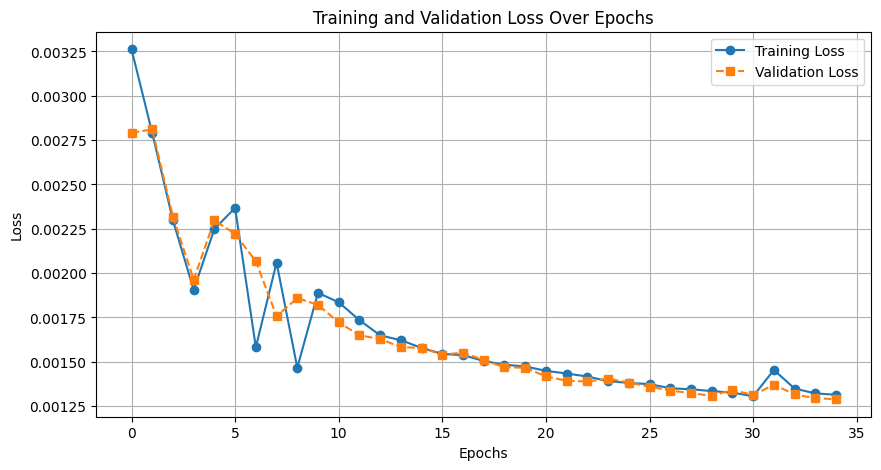

In [25]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(35))

# Validation Loss
validation_loss = [
    0.002791, 0.002811, 0.002319, 0.001963, 0.002298, 0.002221, 0.002067, 0.001758, 0.001859, 0.001821,
    0.001722, 0.00165, 0.001628, 0.001583, 0.001578, 0.001541, 0.001551, 0.00151, 0.001469, 0.001467,
    0.001418, 0.001393, 0.001389, 0.001405, 0.001383, 0.00136, 0.001338, 0.001323, 0.001308, 0.001342,
    0.001312, 0.001371, 0.001316, 0.001295, 0.001289
]

# Training Loss
training_loss = [
    0.003262802, 0.002790507, 0.002297651, 0.001905957, 0.002248957, 0.002368142, 0.001582383, 0.002059401,
    0.00146703, 0.001889008, 0.001835531, 0.001735, 0.001649, 0.001622, 0.001578, 0.001545, 0.001537, 0.001505,
    0.001483, 0.001474, 0.001449, 0.001434, 0.001417, 0.001391, 0.001381, 0.001374, 0.001351, 0.001345,
    0.001335, 0.001326, 0.001306, 0.001454, 0.001349, 0.001322, 0.001314
]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label="Training Loss", marker="o", linestyle="-")
plt.plot(epochs, validation_loss, label="Validation Loss", marker="s", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


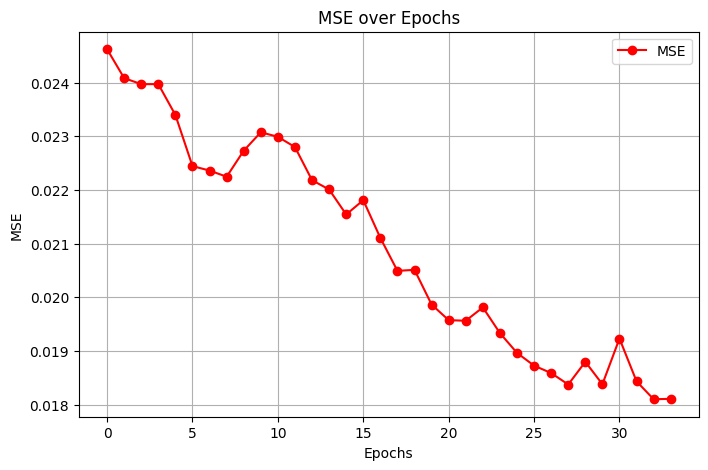

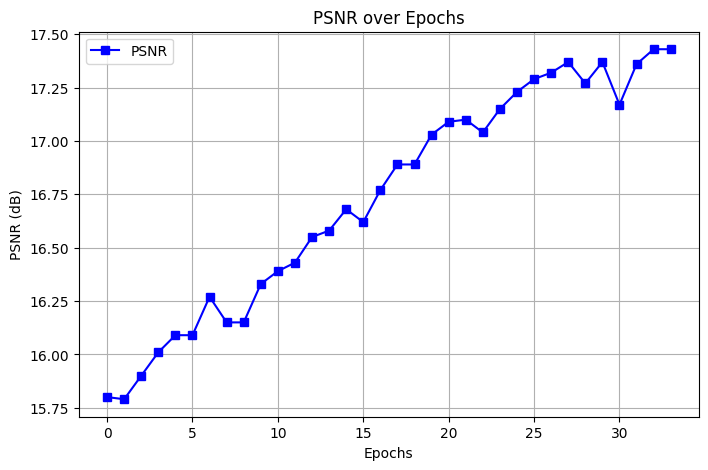

In [4]:
import matplotlib.pyplot as plt

# Define MSE values
mse_values = [
    0.024625, 0.024086, 0.023974, 0.023974, 0.023399, 0.022446, 0.022363, 0.022248, 0.022733, 0.023077,
    0.022992, 0.022801, 0.022183, 0.022010, 0.021544, 0.021811, 0.021107, 
    0.020493, 0.020512, 0.019865, 0.019574, 0.019563, 0.019812, 0.019333, 
    0.018964, 0.018726, 0.018588, 0.018374, 0.018798, 0.018379, 0.019231, 
    0.018433, 0.018100, 0.018107
]

# Define PSNR values
psnr_values = [
    15.80, 15.79, 15.90, 16.01, 16.09, 16.09, 16.27, 16.15, 16.15, 16.33,
    16.39, 16.43, 16.55, 16.58, 16.68, 16.62, 16.77, 
    16.89, 16.89, 17.03, 17.09, 17.10, 17.04, 17.15, 
    17.23, 17.29, 17.32, 17.37, 17.27, 17.37, 17.17, 
    17.36, 17.43, 17.43
]

# Adjust epochs range to match the data length
epochs = list(range(len(mse_values)))

# Plot MSE
plt.figure(figsize=(8, 5))
plt.plot(epochs, mse_values, marker='o', linestyle='-', color='red', label='MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('MSE over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot PSNR
plt.figure(figsize=(8, 5))
plt.plot(epochs, psnr_values, marker='s', linestyle='-', color='blue', label='PSNR')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.title('PSNR over Epochs')
plt.legend()
plt.grid(True)
plt.show()


# Prediction

<ipython-input-17-a82577083cb9>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


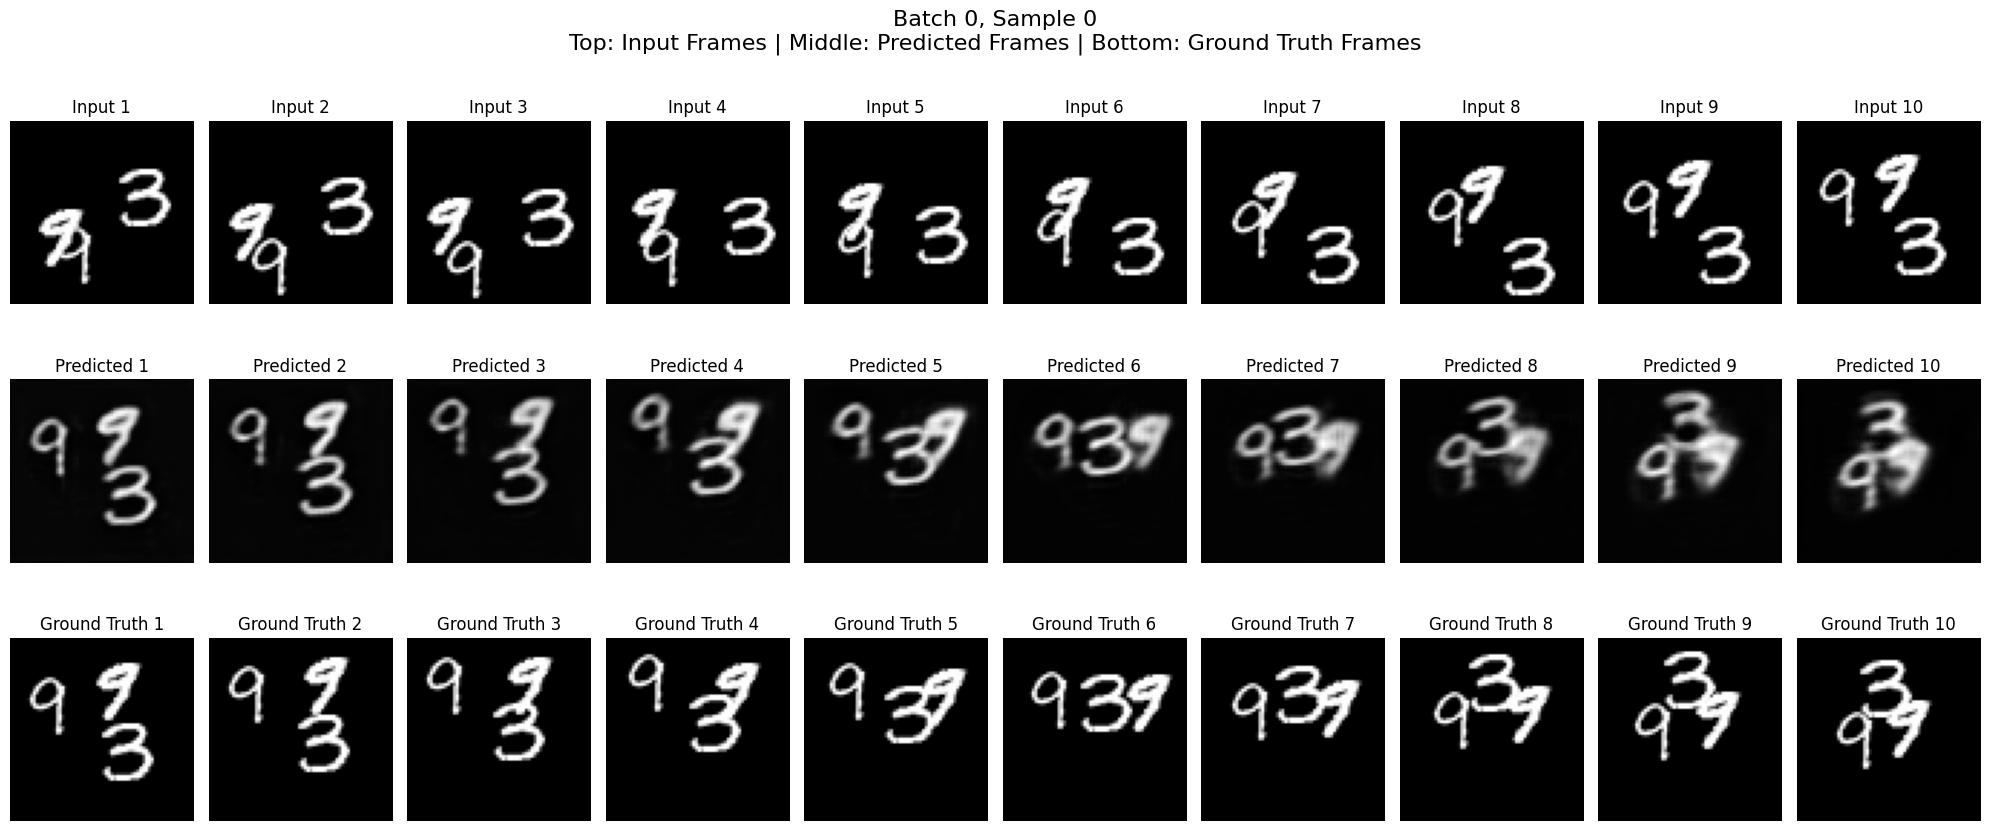

In [17]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


encoder_params = convgru_encoder_params
decoder_params = convgru_decoder_params
# Load the model architecture
encoder = Encoder(encoder_params[0], encoder_params[1])
decoder = Decoder(decoder_params[0], decoder_params[1])
net = ED(encoder, decoder)

# Load the checkpoint
checkpoint_path = r'/kaggle/input/conv_mnist/pytorch/default/1/checkpoint_35_0.001289.pth.tar'
checkpoint = torch.load(checkpoint_path)

# Load the model state dict
net.load_state_dict(checkpoint['state_dict'])

# Move the model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Set the model to evaluation mode
net.eval()

# Prepare the data
validFolder = MovingMNIST(is_train=False,
                          root='/kaggle/input/mnist-data',
                          n_frames_input=10,
                          n_frames_output=10,  # Ensure same input and output frames
                          num_objects=[3])

validLoader = DataLoader(validFolder, batch_size=4, shuffle=False)

# Parameters for limiting predictions
num_batches_to_process = 1  # Number of batches to process
num_samples_per_batch = 1   # Number of samples per batch to process

# Make predictions and display input vs predicted vs ground truth frames
with torch.no_grad():
    for batch_idx, (idx, targetVar, inputVar, _, _) in enumerate(validLoader):
        if batch_idx >= num_batches_to_process:
            break  # Stop after processing the specified number of batches

        inputs = inputVar.to(device)
        targets = targetVar.to(device)

        # Predict the next frames
        pred = net(inputs)

        # Convert to NumPy
        inputs = inputs.cpu().numpy()
        targets = targets.cpu().numpy()
        pred = pred.cpu().numpy()

        # Iterate over each sample in the batch
        for sample_idx in range(min(num_samples_per_batch, pred.shape[0])):
            # Create a figure to display input, predicted, and ground truth frames
            plt.figure(figsize=(20, 9))

            # Display the input frames (Row 1)
            for i in range(inputs.shape[1]):  # Loop over input frames
                plt.subplot(3, inputs.shape[1], i + 1)  # 3 rows, 10 columns
                frame = inputs[sample_idx, i, 0, :, :]
                frame = (frame - frame.min()) / (frame.max() - frame.min())  # Normalize
                plt.imshow(frame, cmap='gray')
                plt.title(f'Input {i + 1}')
                plt.axis('off')

            # Display the reconstructed frames (Row 2 - Model Predictions)
            for i in range(pred.shape[1]):  # Loop over predicted frames
                plt.subplot(3, pred.shape[1], inputs.shape[1] + i + 1)
                frame = pred[sample_idx, i, 0, :, :]
                frame = (frame - frame.min()) / (frame.max() - frame.min())  # Normalize
                plt.imshow(frame, cmap='gray')
                plt.title(f'Predicted {i + 1}')
                plt.axis('off')

            # Display the ground truth frames (Row 3)
            for i in range(targets.shape[1]):  # Loop over ground truth frames
                plt.subplot(3, targets.shape[1], 2 * inputs.shape[1] + i + 1)
                frame = targets[sample_idx, i, 0, :, :]
                frame = (frame - frame.min()) / (frame.max() - frame.min())  # Normalize
                plt.imshow(frame, cmap='gray')
                plt.title(f'Ground Truth {i + 1}')
                plt.axis('off')

            plt.suptitle(f'Batch {batch_idx}, Sample {sample_idx}\n'
                         f'Top: Input Frames | Middle: Predicted Frames | Bottom: Ground Truth Frames',
                         fontsize=16)
            plt.tight_layout()
            plt.show()

<ipython-input-26-a82577083cb9>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


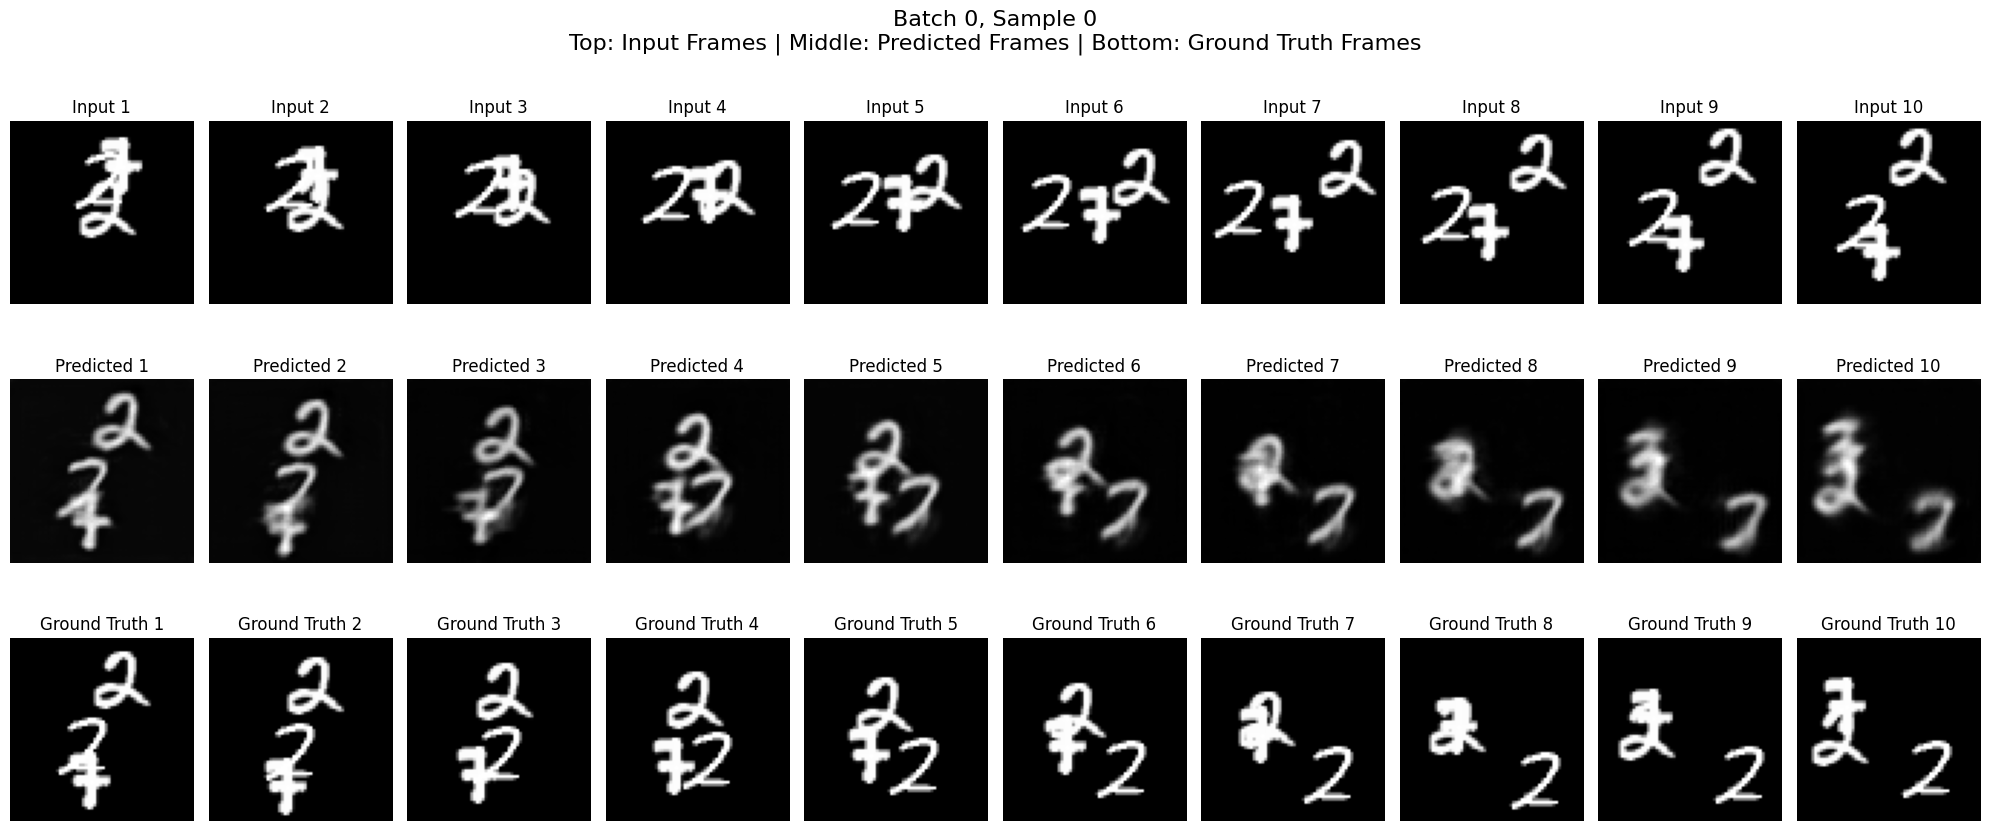

In [26]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


encoder_params = convgru_encoder_params
decoder_params = convgru_decoder_params
# Load the model architecture
encoder = Encoder(encoder_params[0], encoder_params[1])
decoder = Decoder(decoder_params[0], decoder_params[1])
net = ED(encoder, decoder)

# Load the checkpoint
checkpoint_path = r'/kaggle/input/conv_mnist/pytorch/default/1/checkpoint_35_0.001289.pth.tar'
checkpoint = torch.load(checkpoint_path)

# Load the model state dict
net.load_state_dict(checkpoint['state_dict'])

# Move the model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Set the model to evaluation mode
net.eval()

# Prepare the data
validFolder = MovingMNIST(is_train=False,
                          root='/kaggle/input/mnist-data',
                          n_frames_input=10,
                          n_frames_output=10,  # Ensure same input and output frames
                          num_objects=[3])

validLoader = DataLoader(validFolder, batch_size=4, shuffle=False)

# Parameters for limiting predictions
num_batches_to_process = 1  # Number of batches to process
num_samples_per_batch = 1   # Number of samples per batch to process

# Make predictions and display input vs predicted vs ground truth frames
with torch.no_grad():
    for batch_idx, (idx, targetVar, inputVar, _, _) in enumerate(validLoader):
        if batch_idx >= num_batches_to_process:
            break  # Stop after processing the specified number of batches

        inputs = inputVar.to(device)
        targets = targetVar.to(device)

        # Predict the next frames
        pred = net(inputs)

        # Convert to NumPy
        inputs = inputs.cpu().numpy()
        targets = targets.cpu().numpy()
        pred = pred.cpu().numpy()

        # Iterate over each sample in the batch
        for sample_idx in range(min(num_samples_per_batch, pred.shape[0])):
            # Create a figure to display input, predicted, and ground truth frames
            plt.figure(figsize=(20, 9))

            # Display the input frames (Row 1)
            for i in range(inputs.shape[1]):  # Loop over input frames
                plt.subplot(3, inputs.shape[1], i + 1)  # 3 rows, 10 columns
                frame = inputs[sample_idx, i, 0, :, :]
                frame = (frame - frame.min()) / (frame.max() - frame.min())  # Normalize
                plt.imshow(frame, cmap='gray')
                plt.title(f'Input {i + 1}')
                plt.axis('off')

            # Display the reconstructed frames (Row 2 - Model Predictions)
            for i in range(pred.shape[1]):  # Loop over predicted frames
                plt.subplot(3, pred.shape[1], inputs.shape[1] + i + 1)
                frame = pred[sample_idx, i, 0, :, :]
                frame = (frame - frame.min()) / (frame.max() - frame.min())  # Normalize
                plt.imshow(frame, cmap='gray')
                plt.title(f'Predicted {i + 1}')
                plt.axis('off')

            # Display the ground truth frames (Row 3)
            for i in range(targets.shape[1]):  # Loop over ground truth frames
                plt.subplot(3, targets.shape[1], 2 * inputs.shape[1] + i + 1)
                frame = targets[sample_idx, i, 0, :, :]
                frame = (frame - frame.min()) / (frame.max() - frame.min())  # Normalize
                plt.imshow(frame, cmap='gray')
                plt.title(f'Ground Truth {i + 1}')
                plt.axis('off')

            plt.suptitle(f'Batch {batch_idx}, Sample {sample_idx}\n'
                         f'Top: Input Frames | Middle: Predicted Frames | Bottom: Ground Truth Frames',
                         fontsize=16)
            plt.tight_layout()
            plt.show()

<ipython-input-27-a82577083cb9>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


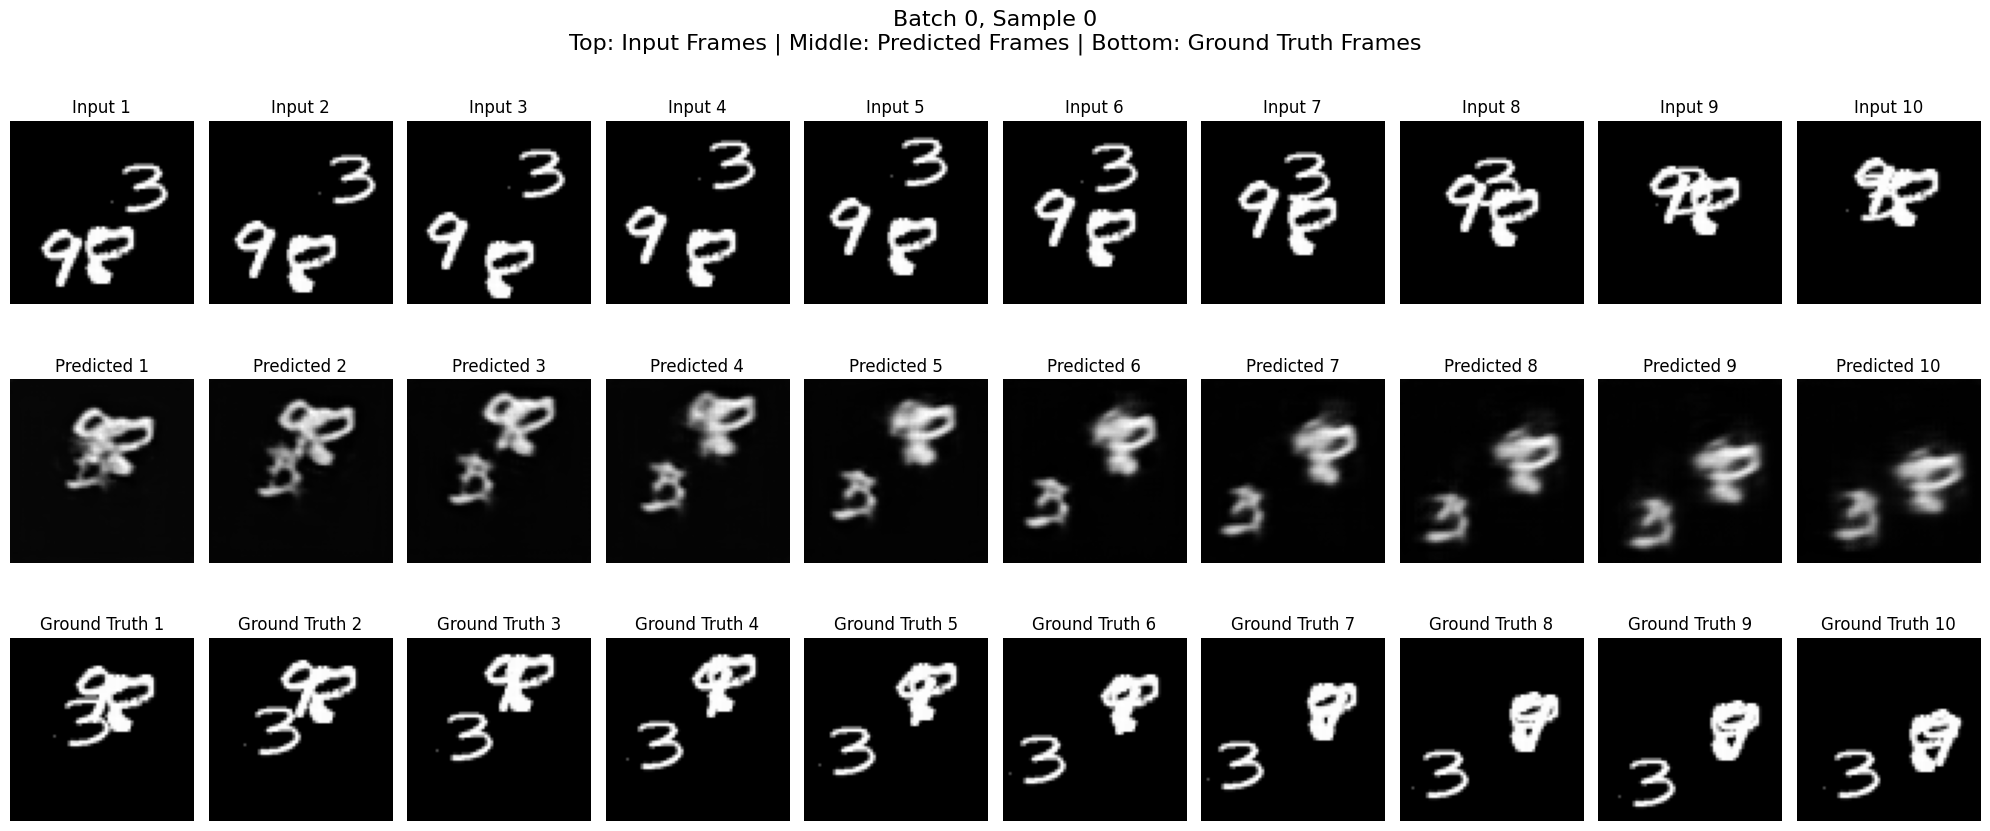

In [27]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


encoder_params = convgru_encoder_params
decoder_params = convgru_decoder_params
# Load the model architecture
encoder = Encoder(encoder_params[0], encoder_params[1])
decoder = Decoder(decoder_params[0], decoder_params[1])
net = ED(encoder, decoder)

# Load the checkpoint
checkpoint_path = r'/kaggle/input/conv_mnist/pytorch/default/1/checkpoint_35_0.001289.pth.tar'
checkpoint = torch.load(checkpoint_path)

# Load the model state dict
net.load_state_dict(checkpoint['state_dict'])

# Move the model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Set the model to evaluation mode
net.eval()

# Prepare the data
validFolder = MovingMNIST(is_train=False,
                          root='/kaggle/input/mnist-data',
                          n_frames_input=10,
                          n_frames_output=10,  # Ensure same input and output frames
                          num_objects=[3])

validLoader = DataLoader(validFolder, batch_size=4, shuffle=False)

# Parameters for limiting predictions
num_batches_to_process = 1  # Number of batches to process
num_samples_per_batch = 1   # Number of samples per batch to process

# Make predictions and display input vs predicted vs ground truth frames
with torch.no_grad():
    for batch_idx, (idx, targetVar, inputVar, _, _) in enumerate(validLoader):
        if batch_idx >= num_batches_to_process:
            break  # Stop after processing the specified number of batches

        inputs = inputVar.to(device)
        targets = targetVar.to(device)

        # Predict the next frames
        pred = net(inputs)

        # Convert to NumPy
        inputs = inputs.cpu().numpy()
        targets = targets.cpu().numpy()
        pred = pred.cpu().numpy()

        # Iterate over each sample in the batch
        for sample_idx in range(min(num_samples_per_batch, pred.shape[0])):
            # Create a figure to display input, predicted, and ground truth frames
            plt.figure(figsize=(20, 9))

            # Display the input frames (Row 1)
            for i in range(inputs.shape[1]):  # Loop over input frames
                plt.subplot(3, inputs.shape[1], i + 1)  # 3 rows, 10 columns
                frame = inputs[sample_idx, i, 0, :, :]
                frame = (frame - frame.min()) / (frame.max() - frame.min())  # Normalize
                plt.imshow(frame, cmap='gray')
                plt.title(f'Input {i + 1}')
                plt.axis('off')

            # Display the reconstructed frames (Row 2 - Model Predictions)
            for i in range(pred.shape[1]):  # Loop over predicted frames
                plt.subplot(3, pred.shape[1], inputs.shape[1] + i + 1)
                frame = pred[sample_idx, i, 0, :, :]
                frame = (frame - frame.min()) / (frame.max() - frame.min())  # Normalize
                plt.imshow(frame, cmap='gray')
                plt.title(f'Predicted {i + 1}')
                plt.axis('off')

            # Display the ground truth frames (Row 3)
            for i in range(targets.shape[1]):  # Loop over ground truth frames
                plt.subplot(3, targets.shape[1], 2 * inputs.shape[1] + i + 1)
                frame = targets[sample_idx, i, 0, :, :]
                frame = (frame - frame.min()) / (frame.max() - frame.min())  # Normalize
                plt.imshow(frame, cmap='gray')
                plt.title(f'Ground Truth {i + 1}')
                plt.axis('off')

            plt.suptitle(f'Batch {batch_idx}, Sample {sample_idx}\n'
                         f'Top: Input Frames | Middle: Predicted Frames | Bottom: Ground Truth Frames',
                         fontsize=16)
            plt.tight_layout()
            plt.show()